# <span style="color:green"><center>Diplomado en Big Data</center></span>

# <span style="color:red"><center>Introducción al Procesamiento Paralelo<center></span>

<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">

# Paralelización con `dask.delayed`

##   <span style="color:blue">Profesores</span>

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 

##   <span style="color:blue">Asesora Medios y Marketing digital</span>
 

4. Maria del Pilar Montenegro, pmontenegro88@gmail.com 

## <span style="color:blue">Contenido</span>

* [Introducción](#Introducción)
* [Bases](Bases)
* [Paralelización usando delayed](#Paralelización-usando-delayed)
* [Ejemplo con Pandas groupby](#Ejemplo-con-Pandas-groupby)
* [Usando decoradores directamente](#Usando-decoradores-directamente)
* [Cerrar el cliente](#Cerrar-el-cliente)

## <span style="color:blue">Introducción</span>

En esta sección paralelizamos el código de estilo de ciclos de ejecución  con Dask y `dask.delayed`. A menudo, esta es la única función que necesitará para convertir funciones y usarlas con Dask.

Esta es una forma sencilla de usar `dask` para paralelizar bases de código existentes o construir [sistemas complejos] (https://blog.dask.org/2018/02/09/credit-models-with-dask). 

Esto también nos ayudará a comprender mejor las secciones posteriores.

** Documentación relacionada **

* [Delayed documentation](https://docs.dask.org/en/latest/delayed.html)
* [Delayed screencast](https://www.youtube.com/watch?v=SHqFmynRxVU)
* [Delayed API](https://docs.dask.org/en/latest/delayed-api.html)
* [Delayed examples](https://examples.dask.org/delayed.html)
* [Delayed best practices](https://docs.dask.org/en/latest/delayed-best-practices.html)

Para instalar dask con conda:

In [ ]:
# conda install -c anaconda dask

In [1]:
from dask.distributed import Client

client = Client(n_workers=4)

## <span style="color:blue">Bases</span>

Primero hagamos algunas funciones de juguete, `inc` y` add`, que duerman un rato para simular el trabajo. Luego, ejecutaremos estas funciones normalmente.

En la siguiente sección, paralelizaremos este código.

In [3]:
from time import sleep

def inc(x):
    sleep(1)
    return x+1

def add(x, y):
    sleep(1)
    return(x+y)


Calculamos el tiempo de ejecución de este código normal usando el comando mágico `%% time`, que es una función especial del Jupyter Notebook.

In [4]:
%%time
# esto debe tomar 3 segundos para correr debido a que
# llamamos cada función de manera secuencial, una después de la otra.

x = inc(1)
y = inc(3)
z = add(x, y)

CPU times: user 293 ms, sys: 50.5 ms, total: 344 ms
Wall time: 3 s


## <span style="color:blue">Paralelización usando dask.delayed</span>

Esas dos llamadas de incremento se pueden llamar en paralelo, porque son totalmente independientes entre sí.

Transformaremos las funciones *inc* y *add* usando la función `dask.delayed`. Cuando llamamos a la versión retrasada pasando los argumentos, exactamente como antes, la función original todavía no se llama, por lo que la ejecución de la celda finaliza muy rápidamente. En su lugar, se crea un objeto retrasado, que realiza un seguimiento de la función a llamar y los argumentos que se le pasan.

In [5]:
from dask import delayed

In [6]:
%%time

# Esto corre inmediatamente, todo lo que hace es construir un grafo
x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x,y)

CPU times: user 5.75 ms, sys: 0 ns, total: 5.75 ms
Wall time: 5.64 ms


Esto se ejecutó de inmediato, ya que todavía no ha se ha ejecutado ningún cálculo. Sin embargo, Dask acaba de crear el grafo para hacer el cálculo.

Para observar el grafo usaremos el método *visualize()* del objeto z que es de tipo `Delayed`.

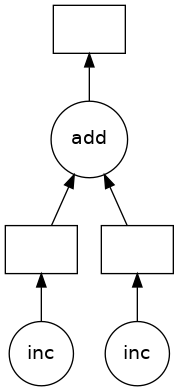

In [7]:
z.visualize()

Para obtener el resultado, llame al método *compute()* del objeto z. Tenga en cuenta que esto se ejecuta más rápido que el código original.

In [7]:
%%time
# Esto realmente ejecuta nuestro cálculo usando un grupo de subprocesos local

z.compute()

CPU times: user 226 ms, sys: 38.6 ms, total: 265 ms
Wall time: 2.08 s


5

In [8]:
z

Delayed('add-e9f06843-12da-44e5-85d1-c279a7dae273')

### ¿Qué es lo que acaba de suceder?

El objeto z es un objeto `Delayed`. Este objeto contiene todo lo que necesitamos para calcular el resultado final, incluidas las referencias a todas las funciones que se requieren y sus entradas y la relación entre sí. 

Podemos evaluar el resultado con el método *compute ()* como arriba o podemos visualizar el gráfico de tareas para este objeto de tipo *Delayed* con el método *visualize ()*.

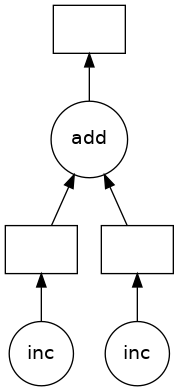

In [7]:
z.visualize()

Observe que esto incluye los nombres de las funciones anteriores y el flujo lógico de las salidas de las funciones inc a las entradas de add.

### Algunas preguntas a considerar:

+ ¿Por qué pasamos de 3 a 2? 
+ ¿Por qué no pudimos paralelizar hasta 1s?
+ ¿Qué hubiera sucedido si las funciones inc y add no incluyeran sleep (1)? 
+ ¿Dask aún podría acelerar este código?
+ ¿Qué pasa si tenemos múltiples salidas o también queremos tener acceso a x o y?

### Ejercicio: paralelizar un bucle for

Los bucles *for* son una de las cosas más comunes que queremos paralelizar. Utilice `dask.delayed` en *inc* y *sum* para paralelizar el cálculo a continuación:

In [9]:
data = [1,2,3,4,5,6,7,8]

In [10]:
%%time
# código secuencial

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

CPU times: user 599 ms, sys: 96.5 ms, total: 696 ms
Wall time: 8.01 s


### Una Solución

Paralelizar. Usaremos *delayed* para retrasar la ejecución. Dask creará el grafo del cómputo y estará listo para ejecutarlo en paralelo.

In [11]:
%%time
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
print('El objeto total es:', total)  # Veámos que cosa es total
result = total.compute()
print('Resultado del cálculo', result)  # Resultado del cálculo


Antes de calcular Delayed('sum-f0f287c3-be1f-415a-96cc-8c2e2c514d04')
Después de calcular 44
CPU times: user 185 ms, sys: 17.2 ms, total: 202 ms
Wall time: 2.06 s


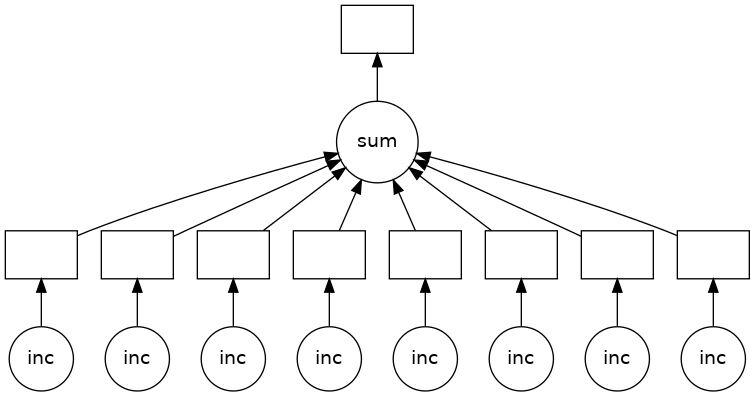

In [12]:
total.visualize()

In [12]:
# tipo de objeto
delayed(inc)(1) + delayed(inc)(2)

Delayed('add-c4e85cbea87be44427591876fa5dce2b')

### Ejercicio: paralelización de un código de bucle for con flujo de control

A menudo queremos retrasar solo algunas funciones, ejecutando algunas de ellas inmediatamente. Esto es especialmente útil cuando esas funciones son rápidas y nos ayudan a determinar qué otras funciones más lentas debemos llamar. Esta decisión, de retrasar o no retrasar, suele ser donde debemos ser reflexivos al utilizar *dask.delayed*.

En el siguiente ejemplo, iteramos a través de una lista de entradas. Si esa entrada es par, entonces queremos llamar a *inc*. Si la entrada es impar, queremos llamar a *doble*. Esta  función de decisión *is_even* para llamar  *inc* o *double* debe tomarse de inmediato (no de manera perezosa) para que el código Python de creación de nuestro gráfo continúe.

In [14]:
def double(x):
    sleep(1)
    return 2*x

def is_even(x):
    return not x%2

data = [1,2,3,4,5,6,7,8,9,10]

In [15]:
%%time
# código secuencial

results = []
for x in data:
    if is_even(x):
        y = inc(x)
    else:
        y = double(x)
    results.append(y)
    
total = sum(results)
print(results)
print(total)

[2, 3, 6, 5, 10, 7, 14, 9, 18, 11]
85
CPU times: user 657 ms, sys: 185 ms, total: 841 ms
Wall time: 10 s


### Código paralelo

In [17]:
%%time

results = []
for x in data:
    if is_even(x):
        y = delayed(inc)(x)
    else:
        y = delayed(double)(x)
    results.append(y)

total = delayed(sum)(results)


CPU times: user 0 ns, sys: 3.7 ms, total: 3.7 ms
Wall time: 4.64 ms


In [18]:
%time total.compute()

CPU times: user 285 ms, sys: 32.6 ms, total: 318 ms
Wall time: 3.08 s


85

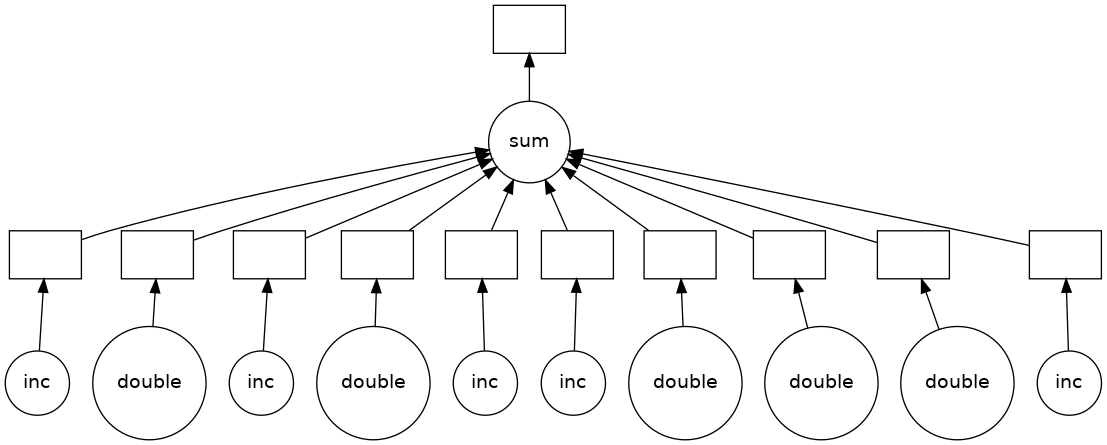

In [17]:
total.visualize()

## <span style="color:blue">Ejemplo con Pandas groupby</span>

Paralelización de  un reducción *groupby* de Pandas

En este ejercicio leemos varios archivos CSV y realizamos una operación *groupby* en paralelo. Primero revisamos un código secuencial para hacer esto y luego lo paralelizamos con *dask.delayed*.

El cálculo que paralelizaremos es calcular el retraso medio de salida por aeropuerto a partir de algunos datos históricos de vuelo. Haremos esto usando *dask.delayed* junto con Pandas. En una sección futura haremos este mismo ejercicio con  `dask.dataframe`.

### Crear datos

Ejecute este código para preparar algunos datos.

Este código descarga y extrae algunos datos históricos de vuelos fuera de Nueva York entre 1990 y 2000. Los datos son originalmente de [ASA](http://stat-computing.org/dataexpo/2009/the-data.html).

In [21]:
!pyhton prep.py -d flights

o 

In [ ]:
%run prep.py -d flights

### Inspección de los datos

In [20]:
import os
sorted(os.listdir(os.path.join('../data', 'nycflights')))

['.ipynb_checkpoints',
 '1990.csv',
 '1991.csv',
 '1992.csv',
 '1993.csv',
 '1994.csv',
 '1995.csv',
 '1996.csv',
 '1997.csv',
 '1998.csv',
 '1999.csv']

Lee un archivo con `pandas.read_csv` y calcula la media de las demoras en salida de vuelos


In [21]:
import pandas as pd
df = pd.read_csv(os.path.join('../data', 'nycflights', '1990.csv'))
df.head()

Year  Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  ArrTime  \
0  1990      1           1          1   1621.0        1540   1747.0   
1  1990      1           2          2   1547.0        1540   1700.0   
2  1990      1           3          3   1546.0        1540   1710.0   
3  1990      1           4          4   1542.0        1540   1710.0   
4  1990      1           5          5   1549.0        1540   1706.0   

   CRSArrTime UniqueCarrier  FlightNum  ...  AirTime  ArrDelay  DepDelay  \
0        1701            US         33  ...      NaN      46.0      41.0   
1        1701            US         33  ...      NaN      -1.0       7.0   
2        1701            US         33  ...      NaN       9.0       6.0   
3        1701            US         33  ...      NaN       9.0       2.0   
4        1701            US         33  ...      NaN       5.0       9.0   

   Origin  Dest  Distance TaxiIn TaxiOut  Cancelled  Diverted  
0     EWR   PIT     319.0    NaN     NaN          0         0  
1     EWR   PIT     319.0    NaN     NaN          0         0  
2     EWR   PIT     319.0    NaN     NaN          0         0  
3     EWR   PIT     319.0    NaN     NaN          0         0  
4     EWR   PIT     319.0    NaN     NaN          0         0  

[5 rows x 23 columns]

In [22]:
# ¿Cuál es el esquema de la tabla?
df.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum              float64
ActualElapsedTime    float64
CRSElapsedTime         int64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance             float64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
Diverted               int64
dtype: object

In [23]:
# ¿A cuáles aeropuertos pertenecen los datos?
df.Origin.unique()

array(['EWR', 'LGA', 'JFK'], dtype=object)

In [24]:
# Promedio de los relatrasos de despegue por aeropuerto para un año (1990)
df.groupby('Origin').DepDelay.mean()

Origin
EWR     9.168411
JFK    11.857274
LGA     8.560045
Name: DepDelay, dtype: float64

### Código secuencial : demora media  en el despegue por aeropuerto.

La celda anterior calcula la demora media de salida por aeropuerto durante un año. Aquí lo ampliamos a todos los años usando un ciclo for secuencial.

Haremos ahora el cálculo global usando todos los archivos de datos disponibles.

In [25]:
from glob import glob
filenames = sorted(glob(os.path.join('../data', 'nycflights', '*.csv')))

In [26]:
filenames

['../data/nycflights/1990.csv',
 '../data/nycflights/1991.csv',
 '../data/nycflights/1992.csv',
 '../data/nycflights/1993.csv',
 '../data/nycflights/1994.csv',
 '../data/nycflights/1995.csv',
 '../data/nycflights/1996.csv',
 '../data/nycflights/1997.csv',
 '../data/nycflights/1998.csv',
 '../data/nycflights/1999.csv']

In [27]:
%%time

sums = []
counts = []
for fn in filenames:
    # lee del archivo
    df = pd.read_csv(fn)
    
    # Agrupa por aeropuerto de origen: groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Número de vuelos por origin
    count = by_origin.DepDelay.count()
    
    # Guarda sumas y conteos intermedias (map reduce)
    sums.append(total)
    counts.append(count)

# Combina los datos intermedios para obtener el dato buscado: mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 8.13 s, sys: 465 ms, total: 8.59 s
Wall time: 8.13 s


In [21]:
counts

[Origin
 EWR    115895
 JFK     46803
 LGA    104947
 Name: DepDelay, dtype: int64,
 Origin
 EWR    112234
 JFK     41832
 LGA    100882
 Name: DepDelay, dtype: int64,
 Origin
 EWR    113801
 JFK     42030
 LGA    101553
 Name: DepDelay, dtype: int64,
 Origin
 EWR    110286
 JFK     41280
 LGA    101122
 Name: DepDelay, dtype: int64,
 Origin
 EWR    112516
 JFK     42243
 LGA     98571
 Name: DepDelay, dtype: int64,
 Origin
 EWR    106398
 JFK     45412
 LGA     96810
 Name: DepDelay, dtype: int64,
 Origin
 EWR    114019
 JFK     42688
 LGA     92367
 Name: DepDelay, dtype: int64,
 Origin
 EWR    118228
 JFK     39246
 LGA     94042
 Name: DepDelay, dtype: int64,
 Origin
 EWR    116028
 JFK     41865
 LGA     91025
 Name: DepDelay, dtype: int64,
 Origin
 EWR    120046
 JFK     43844
 LGA     92948
 Name: DepDelay, dtype: int64]

In [39]:
type(sums[0])

pandas.core.series.Series

In [43]:
sums[0].axes

[Index(['EWR', 'JFK', 'LGA'], dtype='object', name='Origin')]

In [41]:
sums[0].describe

<bound method NDFrame.describe of Origin
EWR    1062573.0
JFK     554956.0
LGA     898351.0
Name: DepDelay, dtype: float64>

### Parallelización del código anterior

Usaremos `dask.delayed` para paralelizar el código anterior.  Necesitamos saber algunas cosas extras.

1.  Los métodos y el acceso a los atributos en los objetos retrasados funcionan automáticamente, por lo que si tiene un objeto retrasado, puede realizar operaciones aritméticas, segmentadas y de métodos normales en él y producirá las llamadas retrasadas correctas.

    ```python
    x = delayed(np.arange)(10)
    y = (x + 1)[::2].sum()  # todo fue retrasado (delayed)
    ```
2.  Llamar al método `.compute ()` funciona bien cuando tiene una única salida. Cuando tenga varias salidas, es posible que desee utilizar la función `dask.compute`:

    ```python
    >>> from dask import compute
    >>> x = delayed(np.arange)(10)
    >>> y = x ** 2
    >>> min_, max_ = compute(y.min(), y.max())
    >>> min_, max_
    (0, 81)
    ```
    
    De esta forma Dask puede compartir los valores intermedios (como `y = x**2`)
    
Entonces, nuestro objetivo es paralelizar el código anterior (que se ha copiado a continuación) usando `dask.delayed`. También es posible que se desee visualizar un poco del cálculo para ver si lo está haciendo correctamente.

In [28]:
from dask import compute

In [29]:
%%time

# copia del código secuencial

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 8.65 s, sys: 175 ms, total: 8.82 s
Wall time: 8.55 s


In [30]:
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

In [ ]:
%%time
# escriba su código paralelizado aquí

Si carga la solución, agregue `%%time` en la parte superior de la celda para medir el tiempo de ejecución.

In [31]:
%%time

# Esta es una posible solución, hay
# varia cosas por hacer usando `delayed`

sums = []
counts = []
for fn in filenames:
    # Retrasa la lectura de los archivos
    df = delayed(pd.read_csv)(fn)

    # Groupby origin airport
    by_origin = df.groupby('Origin')

    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()

    # Number of flights by origin
    count = by_origin.DepDelay.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Compute the intermediates
sums, counts = compute(sums, counts)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 1.12 s, sys: 143 ms, total: 1.26 s
Wall time: 6.61 s


In [48]:
# ensure the results still match
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

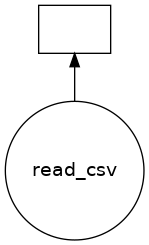

In [55]:
df.visualize()

### Algunas preguntas a considerar:

- ¿Cuánta aceleración obtuviste? ¿Es esta la cantidad de aceleración que esperarías?
- Experimente con dónde llamar a "compute". ¿Qué sucede cuando lo llamas en "sumas" y "recuentos"? ¿Qué pasa si esperas y lo llamas en "mean"?
- Experimente retrasando la llamada a "sum". ¿Cómo se ve el gráfico si se retrasa "suma"? ¿Cómo se ve el gráfico si no lo es?
- ¿Puedes pensar en alguna razón por la que querrías hacer la reducción de una forma sobre la otra?

### Aprende más

Visite la [documentación retrasada] (https://docs.dask.org/en/latest/delayed.html). En particular, este [screencast retrasado] (https://www.youtube.com/watch?v=SHqFmynRxVU) reforzará los conceptos que aprendió aquí y las [mejores prácticas retrasadas] (https://docs.dask.org/ en / latest / delayed-best-practices.html) recopila consejos sobre el uso correcto de `dask.delayed`.

## <span style="color:blue">Usando decoradores directamente</span>

In [32]:
import dask

@dask.delayed
def inc(x):
    return x + 1

@dask.delayed
def double(x):
    return x * 2

@dask.delayed
def add(x, y):
    return x + y

data = [1, 2, 3, 4, 5]

output = []
for x in data:
    a = inc(x)
    b = double(x)
    c = add(a, b)
    output.append(c)

total = dask.delayed(sum)(output)

In [33]:
total.compute()

50

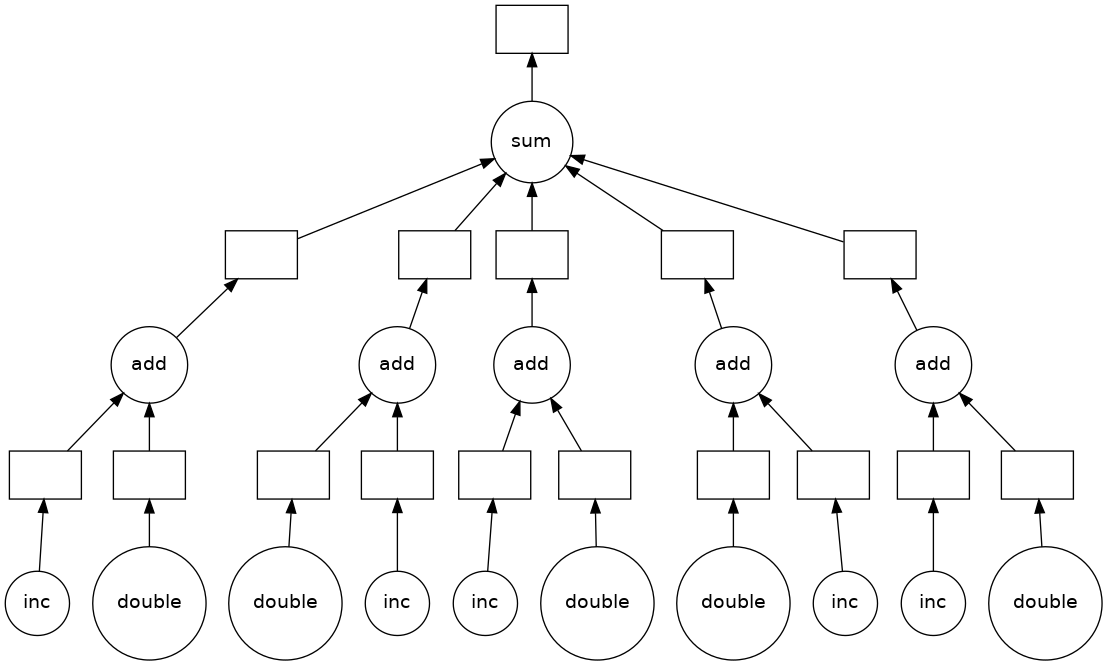

In [58]:
total.visualize()

## <span style="color:blue">Cerrar el cliente</span>

Before moving on to the next exercise, make sure to close your client or stop this kernel.

In [34]:
client.close()